In [156]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.filters import frangi, hessian, try_all_threshold,  threshold_otsu, threshold_li
from skimage import exposure
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_auc_score

def showImages(directory1, directory2, width, height):
    files1 = os.listdir(directory1)
    files2 = os.listdir(directory2)

    for file1, file2 in zip(files1, files2):

        if (file1.endswith(".jpg") or file1.endswith(".tif")) and (file2.endswith(".jpg") or file2.endswith(".tif")):
            img1 = cv2.imread(os.path.join(directory1, file1))

            img_array1 = np.array(img1)


            img2 = cv2.imread(os.path.join(directory2, file2))

            img_array2 = np.array(img2)


            fig, axs = plt.subplots(1, 2, figsize = (10,10))
            axs[0].imshow(cv2.cvtColor(img_array1, cv2.COLOR_BGR2RGB))
            axs[1].imshow(cv2.cvtColor(img_array2, cv2.COLOR_BGR2RGB))
            plt.show()



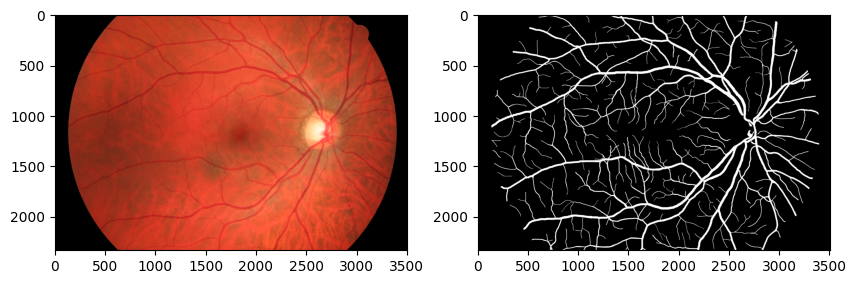

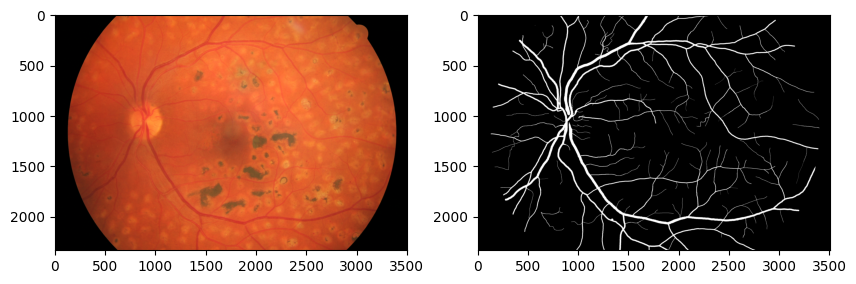

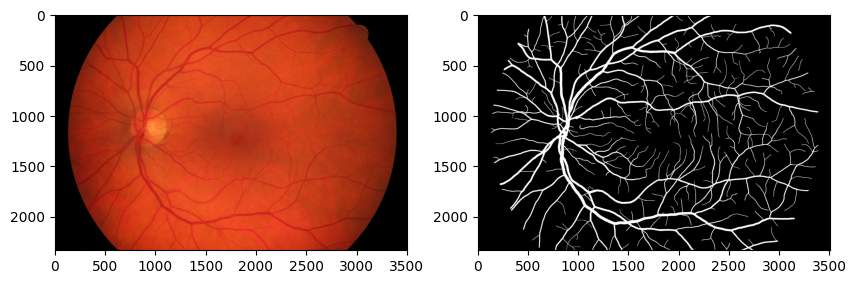

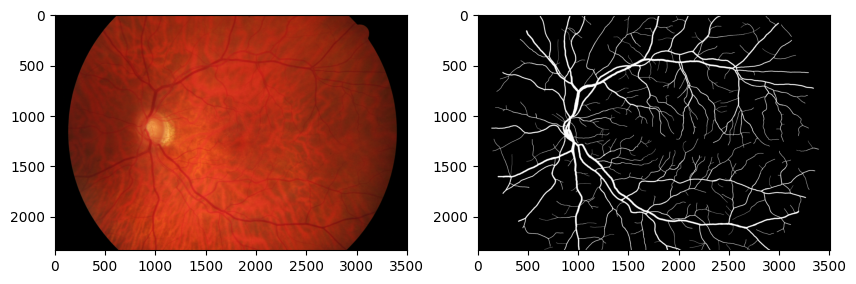

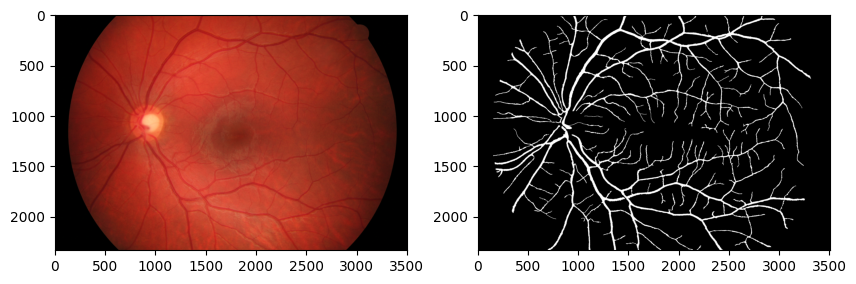

In [105]:
showImages('obrazy/unlabeled', 'obrazy/labeled_m/', 800, 800)



In [162]:
image_names = ["01_h.jpg", "03_dr.jpg", "06_h.jpg", "14_g.jpg", "14_h.jpg"]
# image = cv2.imread('obrazy/unlabeled/01_h.jpg')
# image_labeled = cv2.imread('obrazy/labeled_m/01_h.tif')
# image_mask = cv2.imread('obrazy/masks/01_h_mask.tif')
# image_gray = cv2.cvtColor(image_labeled, cv2.COLOR_BGR2GRAY)
# image_mask = cv2.cvtColor(image_mask, cv2.COLOR_BGR2GRAY)
images = []
images_gray = []
images_mask = []


unlabeled_dir = 'obrazy/unlabeled/'
labeled_dir = 'obrazy/labeled_m/'
masks_dir = 'obrazy/masks/'

for image_name in image_names:
    image_name = image_name[:-4]
    image = cv2.imread(unlabeled_dir + image_name + '.jpg')
    image_labeled = cv2.imread(labeled_dir + image_name + '.tif')
    image_mask = cv2.imread(masks_dir + image_name + '_mask.tif')

    image_gray = cv2.cvtColor(image_labeled, cv2.COLOR_BGR2GRAY)
    image_mask = cv2.cvtColor(image_mask, cv2.COLOR_BGR2GRAY)
    images.append(image)
    images_gray.append(image_gray)
    images_mask.append(image_mask)
print(images)

[array([[[0, 1, 1],
        [0, 1, 1],
        [0, 1, 1],
        ...,
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 1, 1],
        ...,
        [0, 2, 0],
        [0, 2, 0],
        [0, 1, 0]],

       [[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0],
        ...,
        [0, 1, 1],
        [0, 1, 0],
        [0, 1, 0]],

       ...,

       [[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 1, 1],
        [0, 1, 1],
        [0, 1, 1],
        ...,
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]],

       [[0, 1, 1],
        [0, 1, 1],
        [0, 1, 1],
        ...,
        [0, 1, 1],
        [0, 2, 1],
        [0, 2, 1]]], dtype=uint8), array([[[0, 0, 1],
        [0, 0, 1],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [0, 2, 3],
        [0, 1, 2]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,

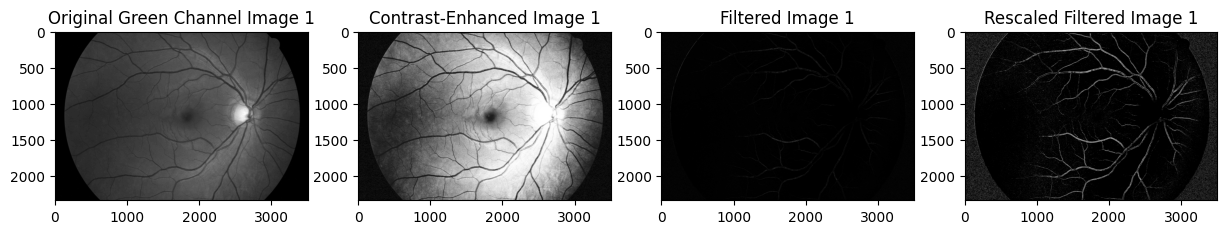

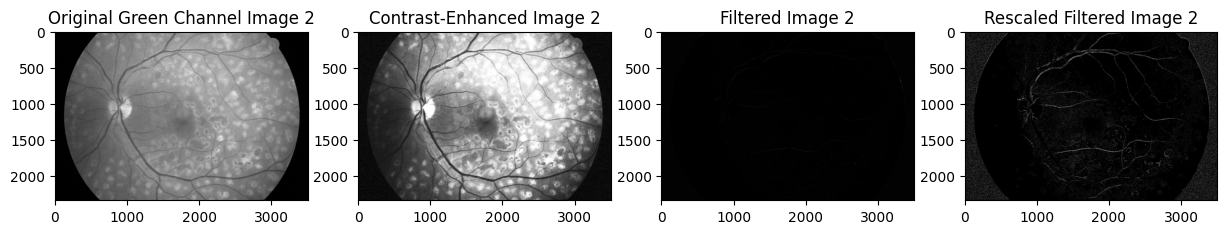

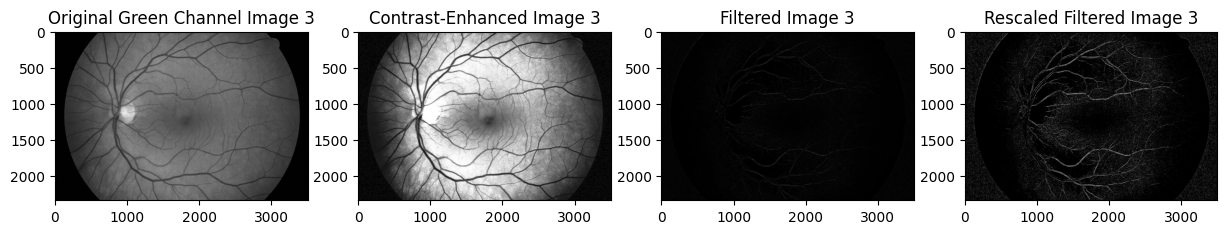

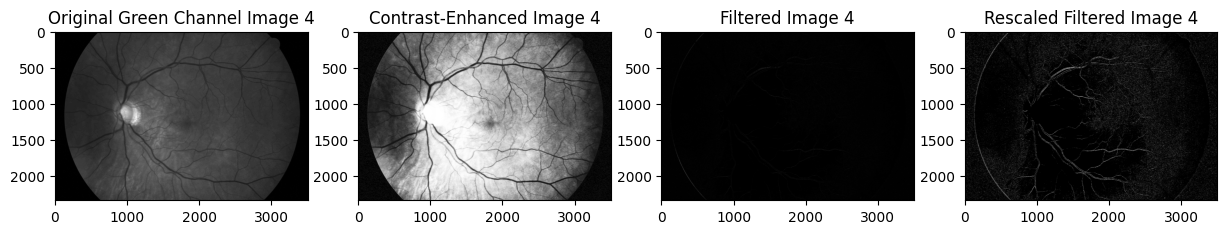

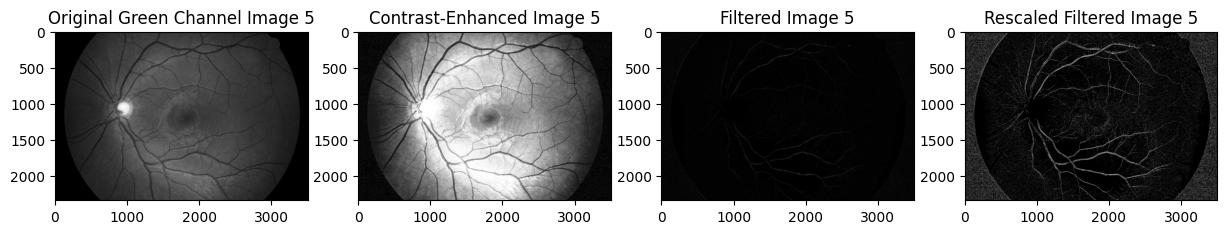

In [172]:
def process_images(images):
    rescaled_images = []
    for i, image in enumerate(images):
        image_green = image[:,:,1]
        image_green_contrast = exposure.equalize_hist(image_green)
        filtered_image = frangi(image_green_contrast)

        rescaled_image = exposure.rescale_intensity(filtered_image, in_range=(0.01, 0.05), out_range=(0,255))

        fig, axs = plt.subplots(1, 4, figsize=(15, 15))

        axs[0].imshow(image_green, cmap='gray')
        axs[0].set_title(f'Original Green Channel Image {i+1}')

        axs[1].imshow(image_green_contrast, cmap='gray')
        axs[1].set_title(f'Contrast-Enhanced Image {i+1}')
        axs[2].imshow(filtered_image, cmap='gray')
        axs[2].set_title(f'Filtered Image {i+1}')
        axs[3].imshow(rescaled_image, cmap='gray')
        axs[3].set_title(f'Rescaled Filtered Image {i+1}')
        rescaled_images.append(rescaled_image)
        plt.show()
    return rescaled_images

rescaled_images = process_images(images)


255.0


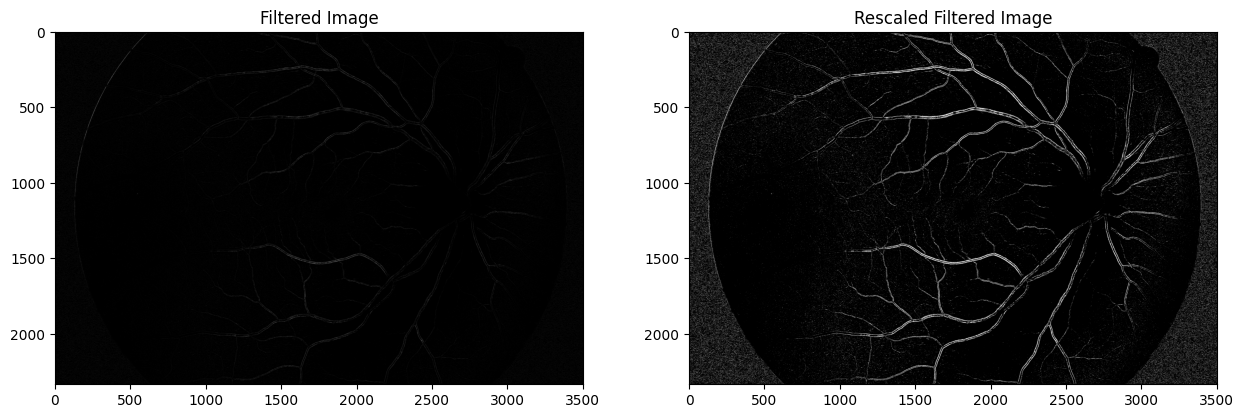

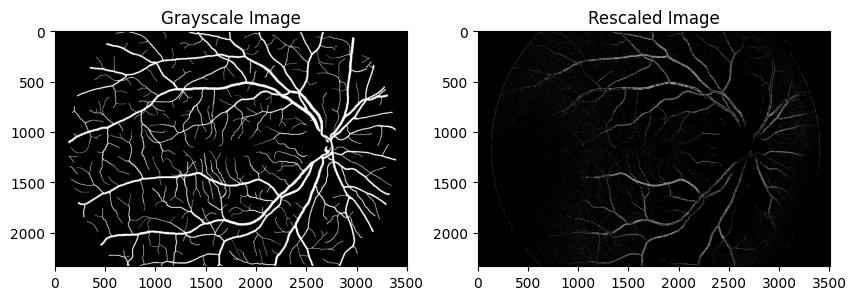

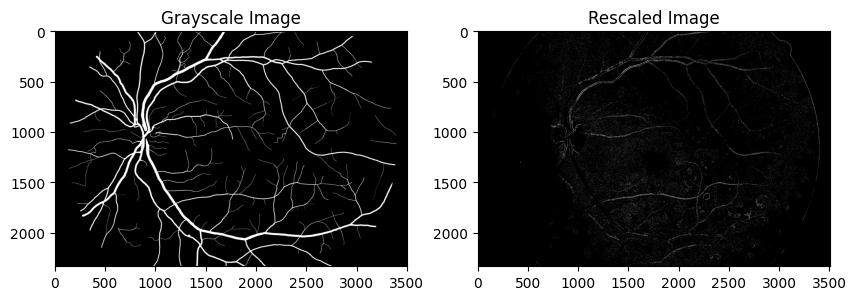

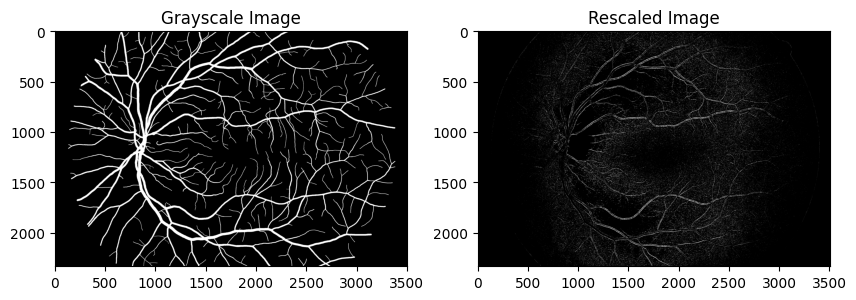

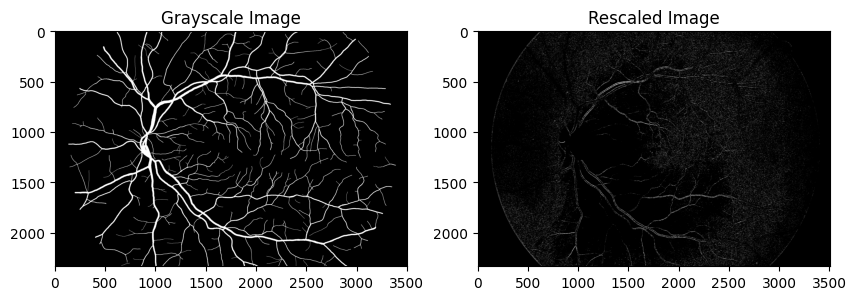

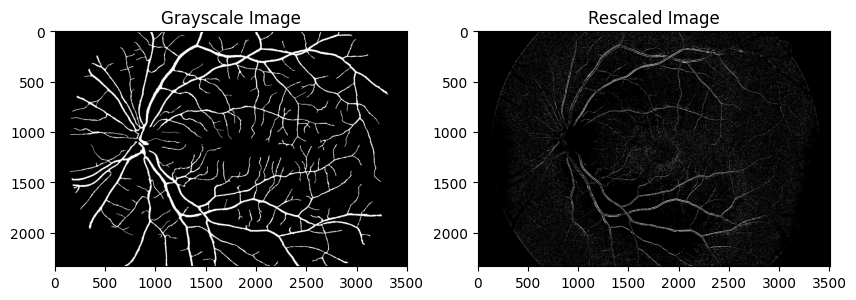

In [176]:
# def mask_compare(rescaled_images, masks, images_gray):
#     masked_images = []
#     for i in  range (len(rescaled_images)):
#         fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#         masked_rescaled_image = np.where(masks[i] > 0, rescaled_images[i], 0)
#         masked_images.append(masked_rescaled_image)
#         axs[0].imshow(images_gray[i], cmap='gray')
#         axs[0].set_title('Grayscale Image')
#         axs[1].imshow(masked_rescaled_image, cmap='gray')
#         axs[1].set_title('Rescaled Image')
#         plt.show()
#     return masked_images
# masked_images = mask_compare(rescaled_images, images_mask, images_gray)

In [159]:
def test_parameters(image, good_image):
    true_labels = good_image.flatten()
    predicted_labels = (image > 0).flatten()
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    accuracy = accuracy_score(true_labels, predicted_labels)
    sensitivity = recall_score(true_labels, predicted_labels)
    specificity = tn / (tn + fp)
    balanced_accuracy = (sensitivity + specificity) / 2
    print(f'Accuracy: {accuracy}')
    print(f'Sensitivity: {sensitivity}')
    print(f'Specificity: {specificity}')
    print(f'Balanced Accuracy: {balanced_accuracy}')


Accuracy: 0.9118100595405642
Sensitivity: 0.7704079908466377
Specificity: 0.9154812603884557
Balanced Accuracy: 0.8429446256175467


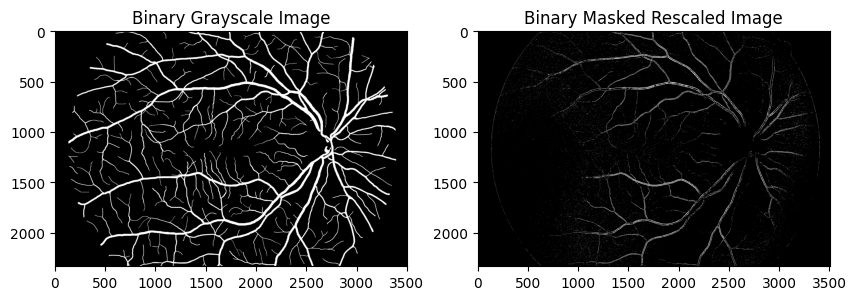

Accuracy: 0.9298380129167448
Sensitivity: 0.2771816123238926
Specificity: 0.9444541315630055
Balanced Accuracy: 0.610817871943449


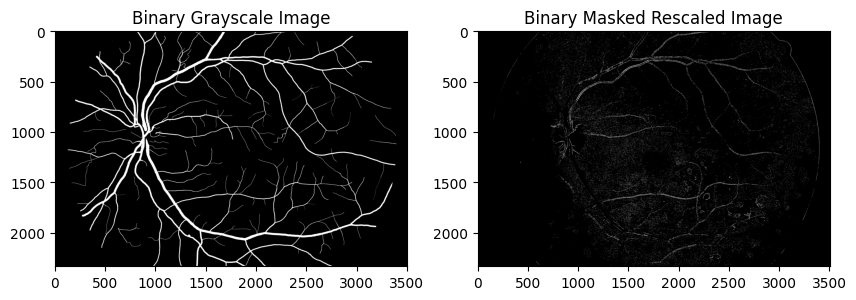

Accuracy: 0.8921930464987177
Sensitivity: 0.42340008218531333
Specificity: 0.9127045324045484
Balanced Accuracy: 0.6680523072949309


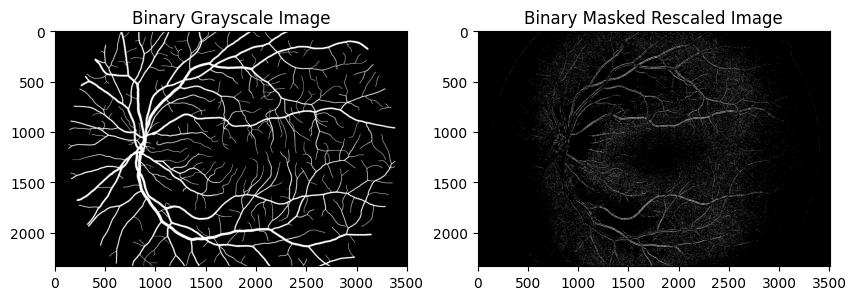

Accuracy: 0.9087750007818853
Sensitivity: 0.2256611095376221
Specificity: 0.9354098813036681
Balanced Accuracy: 0.5805354954206451


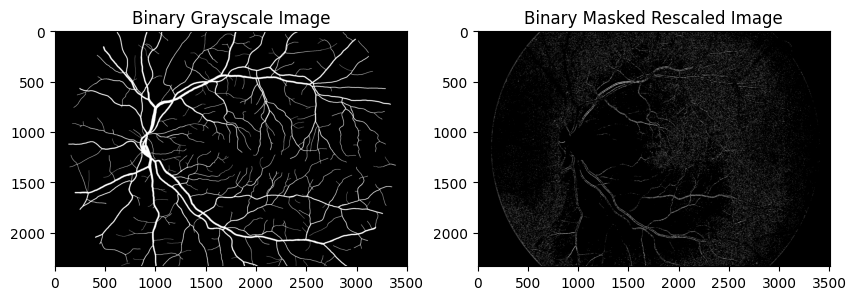

Accuracy: 0.9049874996090573
Sensitivity: 0.41736807398138004
Specificity: 0.9290665096101801
Balanced Accuracy: 0.67321729179578


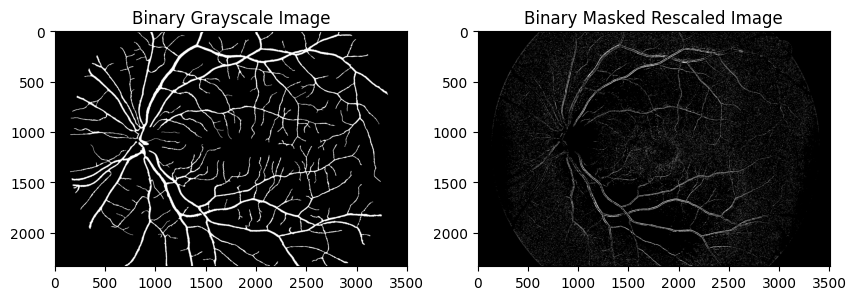

In [178]:
def statistics( masked_images, good_images):
    for i in range(len(masked_images)):
        binary_image_gray = good_images[i] > threshold_otsu(good_images[i])
        binary_masked_rescaled_image = masked_images[i] > threshold_otsu(masked_images[i])
        test_parameters(binary_image_gray, binary_masked_rescaled_image)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))


        axs[0].imshow(binary_image_gray, cmap='gray')
        axs[0].set_title('Binary Grayscale Image')


        axs[1].imshow(binary_masked_rescaled_image, cmap='gray')
        axs[1].set_title('Binary Masked Rescaled Image')


        plt.show()
statistics(masked_images, images_gray)

